In [13]:
from __future__ import print_function, unicode_literals, division
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import numpy as np

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing 

In [14]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(9, 64) 
        self.linear2 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 7) 
        
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.layer_out(x)
        output = F.log_softmax(x, dim=1)
        return output

In [15]:
## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [16]:
def train(model, device, train_loader, optimizer, epoch, epochs):
    model.train()
    correct = 0
    log_interval=10
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('{}/{}\t\t{:.3f}\t\t{:.0f}'.format(
        epoch, epochs,
        loss.item(),100. * correct / len(train_loader.dataset)), end='')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\t\t{:.3f}\t\t{:.0f}\n'.format(test_loss, 100. * correct / len(test_loader.dataset)))
    
def test_prediction(model, device, data, labels):
    with torch.no_grad():
        data = data.to(device)
        output, xx = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

    print(f'Prediction:{classes[pred]}')

6
tensor([1, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 6, 0, 4, 1, 1, 1, 4, 0, 0, 0, 1, 4,
        1, 2, 1, 0, 1, 6, 1, 0, 5, 2, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2, 6, 0,
        5, 1, 5, 6, 1, 1, 1, 1, 1, 4, 6, 6, 0, 5, 1, 1, 4, 4, 0, 0, 5, 0, 1, 6,
        4, 1, 1, 1, 0, 1, 0, 0, 1])

Train Epoch	Train Loss	Train Acc %	Test Loss	Test Acc %

1/10		1.933		5		1.991		5

2/10		1.951		9		1.966		5

3/10		1.944		9		1.949		5

4/10		1.921		9		1.938		5

5/10		1.935		9		1.931		5

6/10		1.903		9		1.926		5

7/10		1.899		9		1.923		5

8/10		1.881		9		1.920		5

9/10		1.875		9		1.919		5

10/10		1.935		9		1.918		5



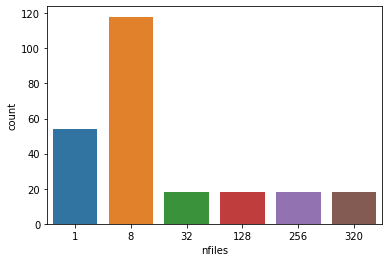

In [17]:
def main():
   
    #read in the dataset
    dataset = pd.read_csv("/home/sansrir/ECE8650/optimizing_checkpoint_restart_project/training_data/combined_training_data.csv")
    sns.countplot(x = 'nfiles', data=dataset)
    dataset = dataset[['strategy','level','tolerance','nodes','processes','writers','ckpt size','avg ckpts time [s]','max ckpt time [s]','avg BW [GB/s]','min BW [GB/s]','nfiles']]
    dataset = dataset[dataset['level'] != 'local']
    dataset = dataset.drop(columns=['level'])
    dataset = dataset.drop(columns=['strategy'])
    
    print(len(dataset['nfiles'].unique()))
    encode_map = {
        1 : 0,
        8 : 1,
        32 : 2,
        64 : 3,
        128 : 4,
        256 : 5,
        320 : 6}
    dataset['nfiles'].replace(encode_map, inplace=True)
    
    # # encode string cols
    # cat_cols = ['strategy']
    # dataset['strategy'] = LabelEncoder().fit_transform(dataset['strategy'])
    # dataset['strategy'] = dataset['strategy'].astype('category')
    # cat_szs = [len(dataset['strategy'].cat.categories)]
    # emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
    
    #define inputs and output -- our output will be num files
    X = dataset.iloc[:,0:-1]
    y = dataset.iloc[:,-1].to_numpy(dtype=int)
    
    
    #test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)
    
    #Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #labels
    y_train = torch.LongTensor(y_train)
    F.one_hot(y_train, 321)
    print(y_train)
    
    train_data = TrainData(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    test_data = TrainData(torch.FloatTensor(X_test), torch.LongTensor(y_test))
    
    EPOCHS = 10
    BATCH_SIZE = 64
    LR = 0.001
    gamma=0.7
    seed=1
    
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=1)

    device = torch.device("cpu")
    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    action = 'train'

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    if(action == "train"):
        print('\nTrain Epoch\tTrain Loss\tTrain Acc %\tTest Loss\tTest Acc %\n')
        for epoch in range(1, EPOCHS + 1):
            train(model, device, train_loader, optimizer, epoch, EPOCHS)
            test(model, device, test_loader)
            scheduler.step()
        #get current directory, make model folder, write model to generated folder
        curr_dir = os.getcwd()
        model_dir = os.path.join(curr_dir, 'model')
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        torch.save(model.state_dict(), os.path.join(model_dir, "model.ckpt"))
    else:
        model.load_state_dict(torch.load('model/model.ckpt'))
        #get labels
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        images, labels = images.to(device), labels.to(device) # add this line
        
        #### BEGIN CITATION ####
        ##(4) https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
        img = Image.open(sys.argv[2])
        img_t = transform(img)
        img_t = img_t.to(device)
        img_t.unsqueeze_(0)
        model.eval()
        outputs = model(img_t)
        conv_layers = get_conv_layers(model, img_t)
        print_feature_map(conv_layers)
        _, predicted = torch.max(outputs, 1)
        #### END CITATIONS (4) ####
        print('Prediction Result: ' + str(classes[labels[predicted]]))
    

if __name__ == '__main__':
    main()